In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import gc
import warnings
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from itertools import product
from mlxtend.feature_selection import SequentialFeatureSelector

warnings.filterwarnings('ignore')

pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option("display.max_colwidth", 100)
pd.set_option('display.width', 1000)

In [2]:
# 节省内存读文件
def reduce_mem_usage(df):
    """
    iterate through all the columns of a dataframe and modify the data type to reduce memory usage.
    @param df:
    @return:
    """
    start_mem = df.memory_usage().sum()
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('str')

    end_mem = df.memory_usage().sum()
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
class MeanEncoder:
    def __init__(self, categorical_features, n_splits=10, target_type='classification', prior_weight_func=None):
        """
        :param categorical_features: list of str, the name of the categorical columns to encode
 
        :param n_splits: the number of splits used in mean encoding
        
        :param target_type: str, 'regression' or 'classification'
 
        :param prior_weight_func:
        a function that takes in the number of observations, and outputs prior weight
        when a dict is passed, the default exponential decay function will be used:
        k: the number of observations needed for the posterior to be weighted equally as the prior
        f: larger f --> smaller slope
        """
 
        self.categorical_features = categorical_features
        self.n_splits = n_splits
        self.learned_stats = {}
 
        if target_type == 'classification':
            self.target_type = target_type
            self.target_values = []
        else:
            self.target_type = 'regression'
            self.target_values = None
 
        if isinstance(prior_weight_func, dict):
            self.prior_weight_func = eval('lambda x: 1 / (1 + np.exp((x - k) / f))', dict(prior_weight_func, np=np))
        elif callable(prior_weight_func):
            self.prior_weight_func = prior_weight_func
        else:
            self.prior_weight_func = lambda x: 1 / (1 + np.exp((x - 2) / 1))
 
    @staticmethod
    def mean_encode_subroutine(X_train, y_train, X_test, variable, target, prior_weight_func):
        X_train = X_train[[variable]].copy()
        X_test = X_test[[variable]].copy()
 
        if target is not None:
            nf_name = '{}_pred_{}'.format(variable, target)
            X_train['pred_temp'] = (y_train == target).astype(int)  # classification
        else:
            nf_name = '{}_pred'.format(variable)
            X_train['pred_temp'] = y_train  # regression
        prior = X_train['pred_temp'].mean()
 
        col_avg_y = X_train.groupby(by=variable, axis=0)['pred_temp'].agg(['mean', 'size'])
        col_avg_y['size'] = prior_weight_func(col_avg_y['size'])
        col_avg_y[nf_name] = col_avg_y['size'] * prior + (1 - col_avg_y['size']) * col_avg_y['mean']
        col_avg_y.drop(['size', 'mean'], axis=1, inplace=True)
 
        nf_train = X_train.join(col_avg_y, on=variable)[nf_name].values
        nf_test = X_test.join(col_avg_y, on=variable).fillna(prior, inplace=False)[nf_name].values
 
        return nf_train, nf_test, prior, col_avg_y
 
    def fit_transform(self, X, y):
        """
        :param X: pandas DataFrame, n_samples * n_features
        :param y: pandas Series or numpy array, n_samples
        :return X_new: the transformed pandas DataFrame containing mean-encoded categorical features
        """
        X_new = X.copy()
        if self.target_type == 'classification':
            skf = StratifiedKFold(self.n_splits)
        else:
            skf = KFold(self.n_splits)
 
        if self.target_type == 'classification':
            self.target_values = sorted(set(y))
            self.learned_stats = {'{}_pred_{}'.format(variable, target): [] for variable, target in
                                  product(self.categorical_features, self.target_values)}
            for variable, target in product(self.categorical_features, self.target_values):
                nf_name = '{}_pred_{}'.format(variable, target)
                X_new.loc[:, nf_name] = np.nan
                for large_ind, small_ind in skf.split(X, y):
                    nf_large, nf_small, prior, col_avg_y = MeanEncoder.mean_encode_subroutine(
                        X_new.iloc[large_ind], y.iloc[large_ind], X_new.iloc[small_ind], variable, target, self.prior_weight_func)
                    X_new.iloc[small_ind, -1] = nf_small
                    self.learned_stats[nf_name].append((prior, col_avg_y))
        else:
            self.learned_stats = {'{}_pred'.format(variable): [] for variable in self.categorical_features}
            for variable in self.categorical_features:
                nf_name = '{}_pred'.format(variable)
                X_new.loc[:, nf_name] = np.nan
                for large_ind, small_ind in skf.split(X, y):
                    nf_large, nf_small, prior, col_avg_y = MeanEncoder.mean_encode_subroutine(
                        X_new.iloc[large_ind], y.iloc[large_ind], X_new.iloc[small_ind], variable, None, self.prior_weight_func)
                    X_new.iloc[small_ind, -1] = nf_small
                    self.learned_stats[nf_name].append((prior, col_avg_y))
        return X_new
 
    def transform(self, X):
        """
        :param X: pandas DataFrame, n_samples * n_features
        :return X_new: the transformed pandas DataFrame containing mean-encoded categorical features
        """
        X_new = X.copy()
 
        if self.target_type == 'classification':
            for variable, target in product(self.categorical_features, self.target_values):
                nf_name = '{}_pred_{}'.format(variable, target)
                X_new[nf_name] = 0
                for prior, col_avg_y in self.learned_stats[nf_name]:
                    X_new[nf_name] += X_new[[variable]].join(col_avg_y, on=variable).fillna(prior, inplace=False)[
                        nf_name]
                X_new[nf_name] /= self.n_splits
        else:
            for variable in self.categorical_features:
                nf_name = '{}_pred'.format(variable)
                X_new[nf_name] = 0
                for prior, col_avg_y in self.learned_stats[nf_name]:
                    X_new[nf_name] += X_new[[variable]].join(col_avg_y, on=variable).fillna(prior, inplace=False)[
                        nf_name]
                X_new[nf_name] /= self.n_splits
 
        return X_new

In [4]:
train_user = reduce_mem_usage(pd.read_csv('../input/train/train_user.csv'))
test_user = reduce_mem_usage(pd.read_csv('../input/test/test_user.csv'))

Memory usage of dataframe is 635104.00 MB
Memory usage after optimization is: 256532.00 MB
Decreased by 59.6%
Memory usage of dataframe is 81880.00 MB
Memory usage after optimization is: 55295.00 MB
Decreased by 32.5%


In [5]:
# 训练集只取最后一个月的数据
train_user['arpu_202004'] = train_user['arpu_202003']
train_user.drop(['arpu_201908', 'arpu_201909', 'arpu_201910', 'arpu_201911',
                 'arpu_201912', 'arpu_202001', 'arpu_202002', 'arpu_202003'],
                axis=1,
                inplace=True)

In [6]:
df_user = pd.concat([train_user, test_user])

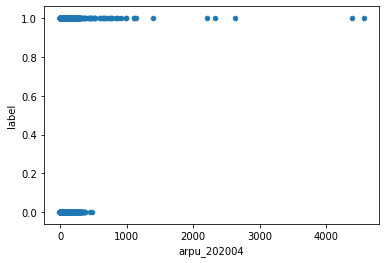

In [7]:
# label与话费额
train_user.plot.scatter(x='arpu_202004', y='label')

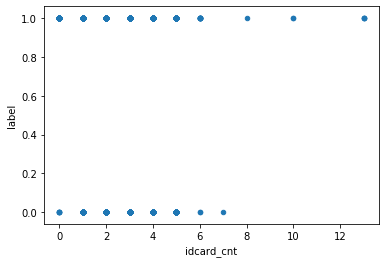

In [8]:
# label与idcard_cnt
train_user.plot.scatter(x='idcard_cnt', y='label')

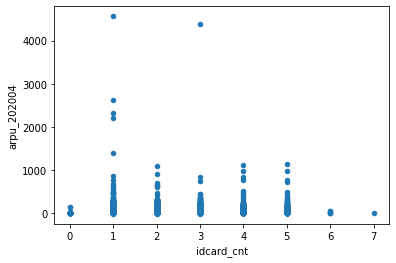

In [9]:
train_user.plot.scatter(x='idcard_cnt', y='arpu_202004')

In [10]:
# 将city_name和county_name拼接起来
df_user['city_name_county_name'] = df_user['city_name'].astype(str) + '_' + df_user['county_name'].astype(str)

In [11]:
# 电话的数量*月消费额
df_user['idcard_cnt*arpu_202004'] = df_user['idcard_cnt'] * df_user['arpu_202004']

# 月消费额/电话的数量
df_user['arpu_202004/idcard_cnt'] = df_user['arpu_202004'] / (df_user['idcard_cnt'] + 0.0001)

In [12]:
cat_feat = ['city_name', 'county_name', 'city_name_county_name']

In [13]:
num_feat = ['idcard_cnt', 'arpu_202004', 'idcard_cnt*arpu_202004']

In [14]:
def cross_cat_num(df, cat_col, num_col):
    for f1 in tqdm(cat_col):
        g = df.groupby(f1, as_index=False)
        for f2 in tqdm(num_col):
            df_new = g[f2].agg({
                '{}_{}_max'.format(f1, f2): 'max',
                '{}_{}_min'.format(f1, f2): 'min',
                '{}_{}_median'.format(f1, f2): 'median',
                '{}_{}_mean'.format(f1, f2): 'mean',
                '{}_{}_skew'.format(f1, f2): 'skew',
                '{}_{}_nunique'.format(f1, f2): 'nunique'
            })
            df = df.merge(df_new, on=f1, how='left')
            del df_new
            gc.collect()
    return df

In [15]:
df_user = cross_cat_num(df_user, cat_feat, num_feat)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.51it/s]


In [16]:
# # LABEL ENCODE
# def label_encode(df, cols, verbose=True):
#     for col in cols:
#         df[col], _ = df[col].factorize(sort=True)
#         if df[col].max() > 32000: 
#             df[col] = df[col].astype('int32')
#         else:
#             df[col] = df[col].astype('int16')
#         if verbose:
#             print(col)

In [17]:
# label_encode(df_user, cat_feat)

In [18]:
def count_encode(df, cols=[]):
    for col in cols:
        print(col)
        vc = df[col].value_counts(dropna=True, normalize=True)
        df[col + '_count'] = df[col].map(vc).astype('float32')

In [19]:
count_encode(df_user, cat_feat + ['idcard_cnt'])

city_name
county_name
city_name_county_name
idcard_cnt


In [20]:
df_user_train = df_user[df_user.label.notna()]
df_user_test = df_user[df_user.label.isna()]

df_user_train.shape, df_user_test.shape

((6106, 67), (2045, 67))

In [21]:
ME = MeanEncoder(categorical_features=cat_feat, n_splits=3, target_type='classification', prior_weight_func=None)
X_data = ME.fit_transform(df_user_train.drop('label', axis=1), df_user_train['label'])
X_test = ME.transform(df_user_test)

In [22]:
# LABEL ENCODE
def label_encode(df, cols, verbose=True):
    for col in cols:
        df[col], _ = df[col].factorize(sort=True)
        if df[col].max() > 32000: 
            df[col] = df[col].astype('int32')
        else:
            df[col] = df[col].astype('int16')
        if verbose:
            print(col)

            
label_encode(X_data, cat_feat)
label_encode(X_test, cat_feat)


# 将类别特征处理为category
for f in cat_feat:
    X_data[f] = X_data[f].astype('category')
    X_test[f] = X_test[f].astype('category')

city_name
county_name
city_name_county_name
city_name
county_name
city_name_county_name


In [23]:
X_train, X_valid, y_train, y_valid = train_test_split(X_data, df_user_train['label'],
                                                      test_size=0.2,
                                                      random_state=2020)

In [24]:
train_cols = [i for i in X_train if i not in ['phone_no_m', 'label']]

In [25]:
params = {'objective': 'binary',
          'boosting': 'gbdt',
          'metric': 'auc',
          'learning_rate': 0.1,
          'num_leaves': 31,
          'lambda_l1': 0,
          'lambda_l2': 1,
          'min_data_in_leaf': 20,
          'is_unbalance': True,
          'max_depth': -1,
          'seed': 2020}

In [26]:
# useful_cols = []
# useless_cols = []

# for i in train_cols:
#     print(i)
#     lgb_train = lgb.Dataset(X_train[[i]].values, y_train) 
#     lgb_eval= lgb.Dataset(X_valid[[i]].values, y_valid, reference=lgb_train)
#     lgb_test = lgb.train(params,
#                          lgb_train,
#                          num_boost_round=1000,
#                          valid_sets=[lgb_eval, lgb_train],
#                          early_stopping_rounds=50,
#                          verbose_eval=20)
    
#     print('*' * 5)
#     print(lgb_test.best_score['valid_0']['auc'])
#     if lgb_test.best_score['valid_0']['auc'] > 0.50:
#         useful_cols.append(i)
#     else:
#         useless_cols.append(i)
#     print('*' * 20)
#     print('\n')

In [27]:
useful_cols = ['arpu_202004', 'city_name', 'county_name', 'idcard_cnt', 'city_name_county_name', 'idcard_cnt*arpu_202004', 'arpu_202004/idcard_cnt', 'city_name_idcard_cnt_max', 'city_name_idcard_cnt_min', 'city_name_idcard_cnt_median', 'city_name_idcard_cnt_mean', 'city_name_idcard_cnt_skew', 'city_name_idcard_cnt_nunique', 'city_name_arpu_202004_max', 'city_name_arpu_202004_min', 'city_name_arpu_202004_median', 'city_name_arpu_202004_mean', 'city_name_arpu_202004_nunique', 'city_name_idcard_cnt*arpu_202004_max', 'city_name_idcard_cnt*arpu_202004_min', 'city_name_idcard_cnt*arpu_202004_median', 'city_name_idcard_cnt*arpu_202004_mean', 'city_name_idcard_cnt*arpu_202004_nunique', 'county_name_idcard_cnt_max', 'county_name_idcard_cnt_min', 'county_name_idcard_cnt_median', 'county_name_idcard_cnt_mean', 'county_name_idcard_cnt_skew', 'county_name_idcard_cnt_nunique', 'county_name_arpu_202004_max', 'county_name_arpu_202004_min', 'county_name_arpu_202004_median', 'county_name_arpu_202004_mean', 'county_name_arpu_202004_skew', 'county_name_arpu_202004_nunique', 'county_name_idcard_cnt*arpu_202004_max', 'county_name_idcard_cnt*arpu_202004_min', 'county_name_idcard_cnt*arpu_202004_median', 'county_name_idcard_cnt*arpu_202004_mean', 'county_name_idcard_cnt*arpu_202004_skew', 'county_name_idcard_cnt*arpu_202004_nunique', 'city_name_county_name_idcard_cnt_max', 'city_name_county_name_idcard_cnt_min', 'city_name_county_name_idcard_cnt_median', 'city_name_county_name_idcard_cnt_mean', 'city_name_county_name_idcard_cnt_skew', 'city_name_county_name_idcard_cnt_nunique', 'city_name_county_name_arpu_202004_max', 'city_name_county_name_arpu_202004_min', 'city_name_county_name_arpu_202004_median', 'city_name_county_name_arpu_202004_mean', 'city_name_county_name_arpu_202004_skew', 'city_name_county_name_arpu_202004_nunique', 'city_name_county_name_idcard_cnt*arpu_202004_max', 'city_name_county_name_idcard_cnt*arpu_202004_min', 'city_name_county_name_idcard_cnt*arpu_202004_median', 'city_name_county_name_idcard_cnt*arpu_202004_mean', 'city_name_county_name_idcard_cnt*arpu_202004_skew', 'city_name_county_name_idcard_cnt*arpu_202004_nunique', 'city_name_count', 'county_name_count', 'city_name_county_name_count', 'idcard_cnt_count', 'city_name_pred_0.0', 'city_name_pred_1.0', 'county_name_pred_0.0', 'county_name_pred_1.0', 'city_name_county_name_pred_0.0', 'city_name_county_name_pred_1.0']

useless_cols = ['city_name_arpu_202004_skew', 'city_name_idcard_cnt*arpu_202004_skew']

In [28]:
print(useful_cols)
print(len(useful_cols))

['arpu_202004', 'city_name', 'county_name', 'idcard_cnt', 'city_name_county_name', 'idcard_cnt*arpu_202004', 'arpu_202004/idcard_cnt', 'city_name_idcard_cnt_max', 'city_name_idcard_cnt_min', 'city_name_idcard_cnt_median', 'city_name_idcard_cnt_mean', 'city_name_idcard_cnt_skew', 'city_name_idcard_cnt_nunique', 'city_name_arpu_202004_max', 'city_name_arpu_202004_min', 'city_name_arpu_202004_median', 'city_name_arpu_202004_mean', 'city_name_arpu_202004_nunique', 'city_name_idcard_cnt*arpu_202004_max', 'city_name_idcard_cnt*arpu_202004_min', 'city_name_idcard_cnt*arpu_202004_median', 'city_name_idcard_cnt*arpu_202004_mean', 'city_name_idcard_cnt*arpu_202004_nunique', 'county_name_idcard_cnt_max', 'county_name_idcard_cnt_min', 'county_name_idcard_cnt_median', 'county_name_idcard_cnt_mean', 'county_name_idcard_cnt_skew', 'county_name_idcard_cnt_nunique', 'county_name_arpu_202004_max', 'county_name_arpu_202004_min', 'county_name_arpu_202004_median', 'county_name_arpu_202004_mean', 'county_na

In [29]:
print(useless_cols)
print(len(useless_cols))

['city_name_arpu_202004_skew', 'city_name_idcard_cnt*arpu_202004_skew']
2


In [30]:
X_data.drop(useless_cols + ['phone_no_m'], axis=1, inplace=True)

In [31]:
# backward_model = SequentialFeatureSelector(lgb.LGBMClassifier(),
#                                            k_features=50,
#                                            forward=False,
#                                            verbose=2,
#                                            cv=3,
#                                            n_jobs=-1,
#                                            scoring='roc_auc')
# backward_model.fit(X_data[useful_cols], df_user_train['label'])
# # backward_model.k_feature_idx_
# backward_cols = X_data.columns[list(backward_model.k_feature_idx_)]
# print(backward_cols)

In [32]:
backward_cols = ['arpu_202004', 'county_name', 'idcard_cnt', 'city_name_county_name', 'arpu_202004/idcard_cnt',
                 'city_name_idcard_cnt_max', 'city_name_idcard_cnt_min', 'city_name_idcard_cnt_median',
                 'city_name_idcard_cnt_mean', 'city_name_idcard_cnt_skew', 'city_name_idcard_cnt_nunique',
                 'city_name_arpu_202004_max', 'city_name_arpu_202004_median', 'city_name_arpu_202004_mean',
                 'city_name_idcard_cnt*arpu_202004_max', 'city_name_idcard_cnt*arpu_202004_min',
                 'city_name_idcard_cnt*arpu_202004_median', 'city_name_idcard_cnt*arpu_202004_mean',
                 'city_name_idcard_cnt*arpu_202004_nunique', 'county_name_idcard_cnt_min', 'county_name_idcard_cnt_mean',
                 'county_name_idcard_cnt_skew', 'county_name_arpu_202004_max', 'county_name_arpu_202004_median',
                 'county_name_arpu_202004_mean', 'county_name_idcard_cnt*arpu_202004_max', 'county_name_idcard_cnt*arpu_202004_min',
                 'county_name_idcard_cnt*arpu_202004_median', 'county_name_idcard_cnt*arpu_202004_mean',
                 'county_name_idcard_cnt*arpu_202004_nunique', 'city_name_county_name_idcard_cnt_max',
                 'city_name_county_name_idcard_cnt_median', 'city_name_county_name_idcard_cnt_mean',
                 'city_name_county_name_idcard_cnt_skew', 'city_name_county_name_idcard_cnt_nunique',
                 'city_name_county_name_arpu_202004_max', 'city_name_county_name_arpu_202004_min',
                 'city_name_county_name_arpu_202004_median', 'city_name_county_name_arpu_202004_mean',
                 'city_name_county_name_arpu_202004_nunique', 'city_name_county_name_idcard_cnt*arpu_202004_max',
                 'city_name_county_name_idcard_cnt*arpu_202004_min', 'city_name_county_name_idcard_cnt*arpu_202004_mean',
                 'city_name_county_name_idcard_cnt*arpu_202004_nunique', 'county_name_count', 'city_name_county_name_count',
                 'idcard_cnt_count', 'city_name_pred_1.0', 'county_name_pred_0.0', 'city_name_county_name_pred_0.0']

In [33]:
len(backward_cols)

50

In [34]:
lgb_data = lgb.Dataset(X_data[backward_cols].values, df_user_train['label'])

cv_results = lgb.cv(params,
                    lgb_data,
                    num_boost_round=1000,
                    early_stopping_rounds=200,
                    eval_train_metric=True,
                    stratified=True,
                    shuffle=True,
                    nfold=3)
cv_df = pd.DataFrame(cv_results)
cv_df

,train auc-mean,train auc-stdv,valid auc-mean,valid auc-stdv
0,0.895675,0.004773,0.852918,0.007802
1,0.903921,0.006593,0.859671,0.006298
2,0.908903,0.005319,0.863274,0.006338
3,0.911374,0.004318,0.864011,0.009195
4,0.914393,0.003144,0.864039,0.009467
5,0.917123,0.003063,0.864989,0.009415
6,0.919367,0.002837,0.865670,0.009962
7,0.921226,0.002485,0.865971,0.008983
8,0.922749,0.002584,0.866897,0.009175
9,0.924485,0.002704,0.867400,0.009199


In [35]:
len(cv_df)

20

In [36]:
lgb_train = lgb.train(params,
                      lgb_data,
                      num_boost_round=len(cv_df),
                      valid_sets=lgb_data,
                      verbose_eval=100)

In [37]:
X_test['label'] = np.where(lgb_train.predict(X_test[backward_cols]) > 0.5, 1, 0)
X_test[['phone_no_m', 'label']].to_csv('../sub/sub_{}.csv'.format(time.strftime('%Y%m%d')), index=False)